# Catastrophic Forgetting

## Introduction

The phenomenon of catastrophic forgetting, or catastrophic interference, was first observed by McCloskey and Cohen (1989). It is especially salient in online learning, where training data is fed sequentially to a machine learning model for training. In this notebook, we will explore the effects of catastrophic interference in the PES learning rule on MNIST data.

In [13]:
import nengo
import numpy as np
import tensorflow as tf
from PIL import Image
from nengo_extras.gui import image_display_function
from nengo_extras.vision import Gabor, Mask
from nengo_extras.data import one_hot_from_labels
from nengo_gui.ipython import IPythonViz


## MNIST Digit Recognition

We will experiment on catastrophic interference with MNIST.

In [14]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
n_train, height, width = X_train.shape
n_test = len(y_test)
n_classes = len(np.unique(y_train))

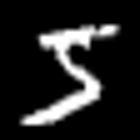

Label: 5
Max Pixel Val: 255
Min Pixel Val: 0


In [15]:
Image.fromarray(X_train[0]) \
    .resize((height * 5, width * 5)) \
    .show()

print(f"Label: {y_train[0]}")
print(f"Max Pixel Val: {np.max(X_train[0])}")
print(f"Min Pixel Val: {np.min(X_train[0])}")

In [16]:
# Batch preprocess the data into unit vector.
def preprocess(X):
    X = X.reshape(len(X), -1)
    X = X - X.mean(axis=1, keepdims=True)
    return X / np.linalg.norm(X, axis=1, keepdims=True)

In [17]:
# Preprocessing and One hot encode
X_train = preprocess(X_train)
y_train = one_hot_from_labels(y_train)
X_test = preprocess(X_test)
y_test = one_hot_from_labels(y_test)

## Neural Network

We build a 2 ensemble neural network with Nengo, and set the learning with PES learning rule.

In [18]:
# Some network configuration hyperparameters
input_display_time = 1
n_neurons = 5000

Neural networks in Nengo are fixed-encoding networks, whereby the encoders are fixed to a certain randomly generated value. Previous research has shown that Gabor filters best extracts the features of an image. Unlike in deep learning, where these Gabor filters are derived from backpropagation, we can only generate these Gabor filters randomly because backpropagation cannot be used in fixed-encoding SNN.

In [19]:
# Generate the encoders for the neural ensemble
gabor_size = (11, 11)
# Set the rng state (using a fixed seed that works)
rng = np.random.RandomState(9)
encoders = Gabor().generate(n_neurons, gabor_size, rng=rng)
encoders = Mask((height, width)).populate(encoders, rng=rng, flatten=True)

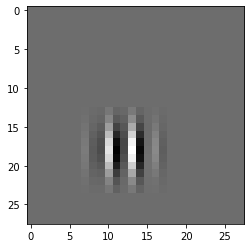

In [20]:
from matplotlib import pyplot as plt
plt.imshow(encoders[1].reshape(28,28), cmap="gray")

Below is the nengo model rendered as an interactive demo in Nengo GUI. You can see the effects of catastrophic forgetting when you inhibit the learning by moving the slider of inhibitor to 1 (Wait for 30s for the simulation to run and learn)

In [31]:
with nengo.Network(seed=3) as model:

    input_node = nengo.Node(
        nengo.processes.PresentInput(X_train, input_display_time),
        label="Input"
    )

    # Pre-synaptic ensemble
    pre_ens = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=height * width,
        radius=1
    )
    
    nengo.Connection(input_node, pre_ens)
    
    post_ens = nengo.Ensemble(
        n_neurons=30*n_classes,
        dimensions=n_classes,
        radius=5
    )
    
    # Connection with synapse weight to be learned by PES
    # Weights are randomly initialized
    conn = nengo.Connection(
        pre_ens, post_ens,
        learning_rule_type=nengo.PES(),
        transform=np.random.rand(n_classes, width*height)
    )
    
    # Error signal representation
    error = nengo.Ensemble(
        n_neurons=30 * n_classes,
        dimensions=n_classes,
        radius=5
    )
    
    gt_node = nengo.Node(
        nengo.processes.PresentInput(y_train, input_display_time),
        label="Ground Truth"
    )
    nengo.Connection(post_ens, error)
    nengo.Connection(gt_node, error, transform=-1)
    nengo.Connection(error, conn.learning_rule)
    
    # Input image display (for nengo_gui)
    image_shape = (1, 28, 28)
    display_func = image_display_function(image_shape, offset=1, scale=128)
    display_node = nengo.Node(display_func, size_in=input_node.size_out)
    nengo.Connection(input_node, display_node, synapse=None)
    
    # Error inhibition control
    inhibitor = nengo.Node([0])
    nengo.Connection(
        inhibitor, error.neurons, 
        transform=-100*np.ones((error.n_neurons, 1))
    )
    

# Network visualization
IPythonViz(model)

You should see that once inhibitor is turned on, the neural network stops learning and just predicts everything as the predicted label of the last seen sample. This means that the last seen sample before inhibition has turned on has caused catastrophic forgetting in the synapse weights between pre-synaptic and post-synaptic neuron ensemble. This needs to be mitigated.